In [25]:
!pip install rapidfuzz

  Obtaining dependency information for rapidfuzz from https://files.pythonhosted.org/packages/c0/f3/67f5c5cd4d728993c48c1dcb5da54338d77c03c34b4903cc7839a3b89faf/rapidfuzz-3.14.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.1 MB/s eta 0:00:00a 0:00:01


In [90]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
from functools import lru_cache
from urllib.parse import urlencode
from requests.adapters import HTTPAdapter, Retry
import time
import pandas as pd
import requests
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
from rapidfuzz import fuzz, process
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Helpers

In [29]:
def normalize_name(name):
    if pd.isna(name):
        return name

    name = name.lower()
    name = name.strip()

    # Remove/standardize punctuation
    replacements = {
        '-': ' ',
        '_': ' ',
        '.': '',
        ',': '',
        "'": '',
        '"': ''
    }
    for old, new in replacements.items():
        name = name.replace(old, new)

    # Remove extra whitespace
    name = ' '.join(name.split())

    return name

In [33]:
def consolidate_names(df, column, threshold=85):
    """
    Groups similar restaurant names together
    threshold: similarity score 0-100 (higher = more strict)
    """
    # First normalize
    df['normalized'] = df[column].apply(normalize_name)

    unique_names = df['normalized'].unique()
    name_mapping = {}
    processed = set()

    for name in unique_names:
        if name in processed:
            continue

        # Find all similar names
        matches = process.extract(
            name,
            unique_names,
            scorer=fuzz.ratio,
            limit=None
        )

        # Group names above threshold
        similar = [match[0] for match in matches if match[1] >= threshold]

        # Use the most common variant as canonical name
        canonical = df[df['normalized'].isin(similar)][column].mode()[0]

        for similar_name in similar:
            name_mapping[similar_name] = canonical
            processed.add(similar_name)

    df['name_standardized'] = df['normalized'].map(name_mapping)
    return df

# Read Initial Dataset

In [34]:
# US Fast Food Dataset
# Downloaded from 
# read csv data
df_ffrests = pd.read_csv('Datafiniti_Fast_Food_Restaurants.csv')
df_ffrests.rename(columns={'postalCode':'zipcode'},inplace=True)

In [35]:
df_ffrests['name_clean'] = df_ffrests['name'].apply(normalize_name)
df = consolidate_names(df_ffrests, 'name', threshold=85)

In [36]:
df_ffrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  object 
 1   dateAdded          10000 non-null  object 
 2   dateUpdated        10000 non-null  object 
 3   address            10000 non-null  object 
 4   categories         10000 non-null  object 
 5   city               10000 non-null  object 
 6   country            10000 non-null  object 
 7   keys               10000 non-null  object 
 8   latitude           10000 non-null  float64
 9   longitude          10000 non-null  float64
 10  name               10000 non-null  object 
 11  zipcode            10000 non-null  object 
 12  province           10000 non-null  object 
 13  sourceURLs         10000 non-null  object 
 14  websites           10000 non-null  object 
 15  name_clean         10000 non-null  object 
 16  normalized         1000

In [40]:
df_ffrests

,id,dateAdded,dateUpdated,address,categories,city,country,keys,latitude,longitude,name,zipcode,province,sourceURLs,websites,name_clean,normalized,name_standardized
0,AVwcmSyZIN2L1WUfmxyw,2015-10-19T23:47:58Z,2018-06-26T03:00:14Z,800 N Canal Blvd,American Restaurant and Fast Food Restaurant,Thibodaux,US,us/la/thibodaux/800ncanalblvd/1780593795,29.814697,-90.814742,SONIC Drive In,70301,LA,https://foursquare.com/v/sonic-drive-in/4b7361...,https://locations.sonicdrivein.com/la/thibodau...,sonic drive in,sonic drive in,SONIC Drive In
1,AVwcmSyZIN2L1WUfmxyw,2015-10-19T23:47:58Z,2018-06-26T03:00:14Z,800 N Canal Blvd,Fast Food Restaurants,Thibodaux,US,us/la/thibodaux/800ncanalblvd/1780593795,29.814697,-90.814742,SONIC Drive In,70301,LA,https://foursquare.com/v/sonic-drive-in/4b7361...,https://locations.sonicdrivein.com/la/thibodau...,sonic drive in,sonic drive in,SONIC Drive In
2,AVwcopQoByjofQCxgfVa,2016-03-29T05:06:36Z,2018-06-26T02:59:52Z,206 Wears Valley Rd,Fast Food Restaurant,Pigeon Forge,US,us/tn/pigeonforge/206wearsvalleyrd/-864103396,35.803788,-83.580553,Taco Bell,37863,TN,https://www.yellowpages.com/pigeon-forge-tn/mi...,"http://www.tacobell.com,https://locations.taco...",taco bell,taco bell,Taco Bell
3,AVweXN5RByjofQCxxilK,2017-01-03T07:46:11Z,2018-06-26T02:59:51Z,3652 Parkway,Fast Food,Pigeon Forge,US,us/tn/pigeonforge/3652parkway/93075755,35.782339,-83.551408,Arby's,37863,TN,http://www.yellowbook.com/profile/arbys_163389...,"http://www.arbys.com,https://locations.arbys.c...",arbys,arbys,Arby's
4,AWQ6MUvo3-Khe5l_j3SG,2018-06-26T02:59:43Z,2018-06-26T02:59:43Z,2118 Mt Zion Parkway,Fast Food Restaurant,Morrow,US,us/ga/morrow/2118mtzionparkway/1305117222,33.562738,-84.321143,Steak 'n Shake,30260,GA,https://foursquare.com/v/steak-n-shake/4bcf77a...,http://www.steaknshake.com/locations/23851-ste...,steak n shake,steak n shake,Steak 'n Shake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AV12gJwna4HuVbed9Ayg,2017-07-24T21:28:46Z,2018-04-07T13:19:06Z,3460 Robinhood Rd,Fast Food Restaurants,Winston-Salem,US,us/nc/winston-salem/3460robinhoodrd/-66712705,36.117563,-80.316553,Pizza Hut,27106,NC,https://www.allmenus.com/nc/winston-salem/7341...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut
9996,AV12gJxKIxWefVJwhpzS,2017-07-24T21:28:46Z,2018-04-07T13:19:05Z,3069 Kernersville Rd,Fast Food Restaurants,Winston-Salem,US,us/nc/winston-salem/3069kernersvillerd/-66712705,36.077718,-80.176748,Pizza Hut,27107,NC,https://www.allmenus.com/nc/winston-salem/7340...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut
9997,AVwdJMdSByjofQCxl8Vr,2015-10-24T00:17:32Z,2018-04-07T13:19:05Z,838 S Main St,Fast Food Restaurants,Kernersville,US,us/nc/kernersville/838smainst/-66712705,36.111015,-80.089165,Pizza Hut,27284,NC,https://www.allmenus.com/nc/kernersville/73400...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut
9998,AVwdl2cykufWRAb57ZPs,2016-04-05T02:59:45Z,2018-04-07T13:19:05Z,1702 Glendale Dr SW,Fast Food Restaurants,Wilson,US,us/nc/wilson/1702glendaledrsw/-66712705,35.719981,-77.945795,Pizza Hut,27893,NC,https://www.allmenus.com/nc/wilson/73403-pizza...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut


In [39]:
df_ffrests.name_standardized.nunique()

516

In [41]:
df_ffrests.name_standardized.value_counts()

name_standardized
McDonald's                      1951
Taco Bell                       1032
Subway                           849
Burger King                      834
Arby's                           666
                                ... 
Abruzzi Pizza                      1
Cafe Paris                         1
Boddie Noell Enterprises Inc       1
My Daddy's Pizza & Grille          1
Stoko's                            1
Name: count, Length: 516, dtype: int64

In [43]:
# Interactive scatter plot on US map
fig = px.scatter_geo(
    df_ffrests,
    lat="latitude",
    lon="longitude",
    color="name_standardized",
    hover_name="name_standardized",
    scope="usa",       # restricts the map to the US
    projection="albers usa",  # US-friendly projection
    height=1200,
    width=1800
)

fig.update_traces(marker=dict(size=6, opacity=0.7))  # adjust dot size/opacity
fig.show()

# Real Estate Cost
Public sources used (no API key required):
U.S. Census Bureau Geocoder API (coordinates → tract) and American Community Survey (ACS) 5-year API (B25064_001E: Median Gross Rent; B25077_001E: Median Home Value). See U.S. Census Bureau API documentation and ACS 5-year Subject Definitions for these tables.

In [44]:
def download_zillow_data():
    """
    Download Zillow Home Value Index (ZHVI) data
    This is publicly available data updated monthly
    """
    # Zillow Research Data - Single Family Homes ZHVI
    url = "https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"

    print("Downloading Zillow ZHVI data...")
    try:
        zhvi_df = pd.read_csv(url, encoding='utf-8')
        print(f"Successfully downloaded {len(zhvi_df)} ZIP codes")
        return zhvi_df
    except Exception as e:
        print(f"Error downloading Zillow data: {e}")
        return None

def prepare_zillow_data(zhvi_df):
    """
    Prepare Zillow data by selecting the most recent month's value
    """
    # Get the most recent date column (last column with date)
    date_columns = [col for col in zhvi_df.columns if col.startswith('20')]
    most_recent_date = date_columns[-1]

    # Select relevant columns
    zillow_clean = zhvi_df[['RegionName', 'City', 'State', 'Metro', most_recent_date]].copy()
    zillow_clean.columns = ['zipcode', 'city', 'state', 'metro', 'median_home_value']

    # Convert zipcode to string and pad with zeros
    zillow_clean['zipcode'] = zillow_clean['zipcode'].astype(str).str.zfill(5)

    # Remove rows with missing values
    zillow_clean = zillow_clean.dropna(subset=['median_home_value'])

    print(f"Prepared data with {len(zillow_clean)} ZIP codes")
    return zillow_clean

def merge_realestate_data(restaurants_df):
    """
    Main function to merge real estate cost data with restaurant locations
    Assumes restaurants_df already has a 'zipcode' column
    """
    # Download and prepare Zillow data
    print("Downloading Zillow ZHVI data...")
    zhvi_df = download_zillow_data()
    if zhvi_df is None:
        print("Failed to download Zillow data")
        return restaurants_df

    zillow_clean = prepare_zillow_data(zhvi_df)

    # Ensure zipcode format matches (5-digit string with leading zeros)
    restaurants_df['zipcode'] = restaurants_df['zipcode'].astype(str).str.zfill(5)

    # Merge with Zillow data - this is a simple and efficient join operation
    print("\nMerging with real estate data...")
    merged_df = restaurants_df.merge(
        zillow_clean[['zipcode', 'median_home_value', 'city', 'state', 'metro']],
        on='zipcode',
        how='left'
    )

    matched = merged_df['median_home_value'].notna().sum()
    print(f"\nSuccessfully matched {matched} out of {len(merged_df)} restaurants ({matched/len(merged_df)*100:.1f}%)")

    # Show unmatched ZIP codes if any
    unmatched = merged_df[merged_df['median_home_value'].isna()]['zipcode'].unique()
    if len(unmatched) > 0:
        print(f"Unmatched ZIP codes: {unmatched[:10]}")  # Show first 10

    return merged_df

In [15]:
# Run the merge
if __name__ == "__main__":
    result_df = merge_realestate_data(df_ffrests)

    # Display results
    print("\nFinal DataFrame:")
    print(result_df)

    # Save to CSV
    result_df.to_csv('restaurants_with_realestate.csv', index=False)
    print("\nColumns in final dataframe:", result_df.columns.tolist())

Processing restaurant 3314/10000
Processing restaurant 3315/10000
Successfully downloaded 26313 ZIP codes
Prepared data with 26311 ZIP codes

Merging with real estate data...

Successfully matched 9942 out of 10000 restaurants (99.4%)
Unmatched ZIP codes: ['78146' '61112' '97204' '57365' '92008' '02201' '15231' '10475' '55402'
 '76155']

Final DataFrame:
                        id             dateAdded           dateUpdated  \
0     AVwcmSyZIN2L1WUfmxyw  2015-10-19T23:47:58Z  2018-06-26T03:00:14Z   
1     AVwcmSyZIN2L1WUfmxyw  2015-10-19T23:47:58Z  2018-06-26T03:00:14Z   
2     AVwcopQoByjofQCxgfVa  2016-03-29T05:06:36Z  2018-06-26T02:59:52Z   
3     AVweXN5RByjofQCxxilK  2017-01-03T07:46:11Z  2018-06-26T02:59:51Z   
4     AWQ6MUvo3-Khe5l_j3SG  2018-06-26T02:59:43Z  2018-06-26T02:59:43Z   
...                    ...                   ...                   ...   
9995  AV12gJwna4HuVbed9Ayg  2017-07-24T21:28:46Z  2018-04-07T13:19:06Z   
9996  AV12gJxKIxWefVJwhpzS  2017-07-24T21:28:46Z  2

In [46]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  object 
 1   dateAdded          10000 non-null  object 
 2   dateUpdated        10000 non-null  object 
 3   address            10000 non-null  object 
 4   categories         10000 non-null  object 
 5   city_x             10000 non-null  object 
 6   country            10000 non-null  object 
 7   keys               10000 non-null  object 
 8   latitude           10000 non-null  float64
 9   longitude          10000 non-null  float64
 10  name               10000 non-null  object 
 11  zipcode            10000 non-null  object 
 12  province           10000 non-null  object 
 13  sourceURLs         10000 non-null  object 
 14  websites           10000 non-null  object 
 15  name_clean         10000 non-null  object 
 16  normalized         1000

In [47]:
result_df

,id,dateAdded,dateUpdated,address,categories,city_x,country,keys,latitude,longitude,...,province,sourceURLs,websites,name_clean,normalized,name_standardized,median_home_value,city_y,state,metro
0,AVwcmSyZIN2L1WUfmxyw,2015-10-19T23:47:58Z,2018-06-26T03:00:14Z,800 N Canal Blvd,American Restaurant and Fast Food Restaurant,Thibodaux,US,us/la/thibodaux/800ncanalblvd/1780593795,29.814697,-90.814742,...,LA,https://foursquare.com/v/sonic-drive-in/4b7361...,https://locations.sonicdrivein.com/la/thibodau...,sonic drive in,sonic drive in,SONIC Drive In,224666.226681,Thibodaux,LA,"Houma-Thibodaux, LA"
1,AVwcmSyZIN2L1WUfmxyw,2015-10-19T23:47:58Z,2018-06-26T03:00:14Z,800 N Canal Blvd,Fast Food Restaurants,Thibodaux,US,us/la/thibodaux/800ncanalblvd/1780593795,29.814697,-90.814742,...,LA,https://foursquare.com/v/sonic-drive-in/4b7361...,https://locations.sonicdrivein.com/la/thibodau...,sonic drive in,sonic drive in,SONIC Drive In,224666.226681,Thibodaux,LA,"Houma-Thibodaux, LA"
2,AVwcopQoByjofQCxgfVa,2016-03-29T05:06:36Z,2018-06-26T02:59:52Z,206 Wears Valley Rd,Fast Food Restaurant,Pigeon Forge,US,us/tn/pigeonforge/206wearsvalleyrd/-864103396,35.803788,-83.580553,...,TN,https://www.yellowpages.com/pigeon-forge-tn/mi...,"http://www.tacobell.com,https://locations.taco...",taco bell,taco bell,Taco Bell,413481.431557,Pigeon Forge,TN,"Sevierville, TN"
3,AVweXN5RByjofQCxxilK,2017-01-03T07:46:11Z,2018-06-26T02:59:51Z,3652 Parkway,Fast Food,Pigeon Forge,US,us/tn/pigeonforge/3652parkway/93075755,35.782339,-83.551408,...,TN,http://www.yellowbook.com/profile/arbys_163389...,"http://www.arbys.com,https://locations.arbys.c...",arbys,arbys,Arby's,413481.431557,Pigeon Forge,TN,"Sevierville, TN"
4,AWQ6MUvo3-Khe5l_j3SG,2018-06-26T02:59:43Z,2018-06-26T02:59:43Z,2118 Mt Zion Parkway,Fast Food Restaurant,Morrow,US,us/ga/morrow/2118mtzionparkway/1305117222,33.562738,-84.321143,...,GA,https://foursquare.com/v/steak-n-shake/4bcf77a...,http://www.steaknshake.com/locations/23851-ste...,steak n shake,steak n shake,Steak 'n Shake,220622.542671,Morrow,GA,"Atlanta-Sandy Springs-Alpharetta, GA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AV12gJwna4HuVbed9Ayg,2017-07-24T21:28:46Z,2018-04-07T13:19:06Z,3460 Robinhood Rd,Fast Food Restaurants,Winston-Salem,US,us/nc/winston-salem/3460robinhoodrd/-66712705,36.117563,-80.316553,...,NC,https://www.allmenus.com/nc/winston-salem/7341...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut,323974.769022,Winston-Salem,NC,"Winston-Salem, NC"
9996,AV12gJxKIxWefVJwhpzS,2017-07-24T21:28:46Z,2018-04-07T13:19:05Z,3069 Kernersville Rd,Fast Food Restaurants,Winston-Salem,US,us/nc/winston-salem/3069kernersvillerd/-66712705,36.077718,-80.176748,...,NC,https://www.allmenus.com/nc/winston-salem/7340...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut,234927.327164,Winston-Salem,NC,"Winston-Salem, NC"
9997,AVwdJMdSByjofQCxl8Vr,2015-10-24T00:17:32Z,2018-04-07T13:19:05Z,838 S Main St,Fast Food Restaurants,Kernersville,US,us/nc/kernersville/838smainst/-66712705,36.111015,-80.089165,...,NC,https://www.allmenus.com/nc/kernersville/73400...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut,314961.929747,Kernersville,NC,"Winston-Salem, NC"
9998,AVwdl2cykufWRAb57ZPs,2016-04-05T02:59:45Z,2018-04-07T13:19:05Z,1702 Glendale Dr SW,Fast Food Restaurants,Wilson,US,us/nc/wilson/1702glendaledrsw/-66712705,35.719981,-77.945795,...,NC,https://www.allmenus.com/nc/wilson/73403-pizza...,http://www.pizzahut.com,pizza hut,pizza hut,Pizza Hut,171400.522868,Wilson,NC,"Wilson, NC"


In [62]:
real_estate_grouped = result_df.groupby('name_standardized').agg(avg_real_estate_cost=('median_home_value','mean'),nmb_of_restaurants=('id','count'))
real_estate_grouped

,avg_real_estate_cost,nmb_of_restaurants
name_standardized,,
7-Eleven,6.761811e+05,19
90 Miles Cuban Cafe,5.255023e+05,1
A's Ace Burgers,1.656631e+06,1
Abruzzi Pizza,2.628848e+05,1
Acropolis Gyro Palace,4.018529e+05,1
...,...,...
Zaxby's,4.516479e+05,2
Zaxby's Chicken Fingers & Buffalo Wings,4.147903e+05,1
Zio's Italian Kitchen,1.666377e+05,2


<Axes: xlabel='nmb_of_restaurants', ylabel='avg_real_estate_cost'>

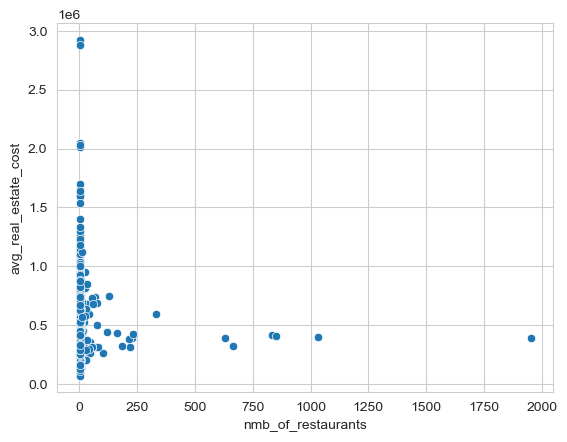

In [64]:
sns.scatterplot(real_estate_grouped, y='avg_real_estate_cost', x='nmb_of_restaurants')

# Nutrition

In [76]:
df_nut = pd.read_csv('nutrition.csv')

In [77]:
df_nut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   restaurant    126 non-null    object 
 1   item          126 non-null    object 
 2   type          126 non-null    object 
 3   servingsize   126 non-null    int64  
 4   calories      126 non-null    int64  
 5   totalfat      126 non-null    float64
 6   saturatedfat  126 non-null    float64
 7   transfat      114 non-null    float64
 8   sodium        126 non-null    int64  
 9   carbs         126 non-null    float64
 10  sugars        126 non-null    float64
 11  protein       126 non-null    float64
dtypes: float64(6), int64(3), object(3)
memory usage: 11.9+ KB


In [78]:
df_nut

,restaurant,item,type,servingsize,calories,totalfat,saturatedfat,transfat,sodium,carbs,sugars,protein
0,McDonald's,Hamburger,Burger,98,240,8.0,3.0,0.0,480,32.0,6.0,12.0
1,McDonald's,Cheeseburger,Burger,113,290,11.0,5.0,0.5,680,33.0,7.0,15.0
2,McDonald's,Big Mac,Burger,211,530,27.0,10.0,1.0,960,47.0,9.0,24.0
3,McDonald's,Quarter Pounder with Cheese,Burger,202,520,26.0,12.0,1.5,1100,41.0,10.0,30.0
4,McDonald's,Bacon Clubhouse Burger,Burger,270,720,40.0,15.0,1.5,1470,51.0,14.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...
121,In-N-Out Burger,Hamburger w/Onion,Burger,243,390,19.0,5.0,0.0,650,39.0,10.0,16.0
122,In-N-Out Burger,Cheeseburger w/Onion,Burger,268,480,27.0,10.0,0.5,1000,39.0,10.0,22.0
123,In-N-Out Burger,Double-Double w/Onion,Burger,330,670,41.0,18.0,1.0,1440,39.0,10.0,37.0
124,In-N-Out Burger,French Fries,French Fries,125,395,18.0,5.0,0.0,245,54.0,0.0,7.0


In [79]:
df_nut.restaurant.nunique()

12

In [80]:
df_nut.groupby('restaurant').agg(nmb_menu_items=('item','count'),avg_fat=('totalfat','mean'))

,nmb_menu_items,avg_fat
restaurant,,
Burger King,11,29.909091
Carl's Jr.,13,34.238462
Chick-fil-A,5,12.300000
Dairy Queen,11,27.090909
Hardee's,12,39.666667
In-N-Out Burger,5,26.800000
Jack in the Box,13,29.384615
McDonald's,11,20.363636
Sonic,11,33.818182


In [85]:
cluster_df = pd.merge(df_nut.groupby('restaurant').agg(nmb_menu_items=('item','count'),avg_fat=('totalfat','mean')), real_estate_grouped.reset_index().rename({'name_standardized':'restaurant'},axis=1), how='left', on='restaurant')
cluster_df

,restaurant,nmb_menu_items,avg_fat,avg_real_estate_cost,nmb_of_restaurants
0,Burger King,11,29.909091,417874.827235,834
1,Carl's Jr.,13,34.238462,747591.058956,127
2,Chick-fil-A,5,12.300000,396009.123950,228
3,Dairy Queen,11,27.090909,318896.929776,218
4,Hardee's,12,39.666667,262249.256402,101
5,In-N-Out Burger,5,26.800000,732383.554791,54
6,Jack in the Box,13,29.384615,599829.131743,332
7,McDonald's,11,20.363636,391521.562674,1951
8,Sonic,11,33.818182,311995.411599,20
9,Wendy's,12,27.250000,394852.192937,628


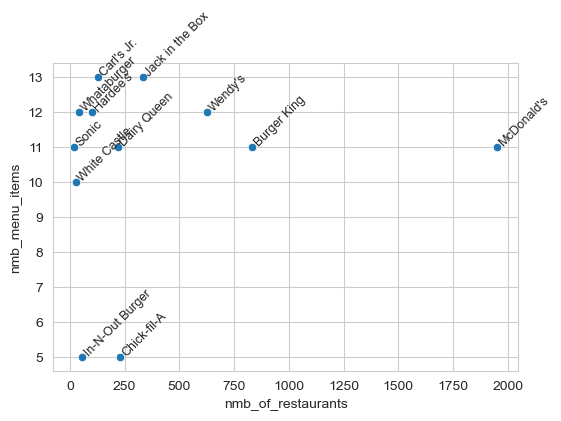

In [87]:
plt.figure(figsize=(6, 4))
ax = sns.scatterplot(cluster_df, x='nmb_of_restaurants',y='nmb_menu_items')
# Add labels from the "label" column
for i, row in cluster_df.iterrows():
    ax.text(row["nmb_of_restaurants"] + 0.05,  # small offset on x
            row["nmb_menu_items"] + 0.05,  # small offset on y
            row["restaurant"],
            fontsize=9, rotation=45)

plt.show()

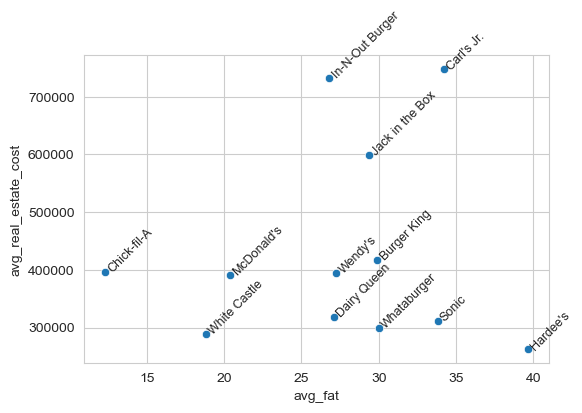

In [89]:
plt.figure(figsize=(6, 4))
ax = sns.scatterplot(cluster_df, x='avg_fat',y='avg_real_estate_cost')
# Add labels from the "label" column
for i, row in cluster_df.iterrows():
    ax.text(row["avg_fat"] + 0.05,  # small offset on x
            row["avg_real_estate_cost"] + 0.05,  # small offset on y
            row["restaurant"],
            fontsize=9, rotation=45)

plt.show()

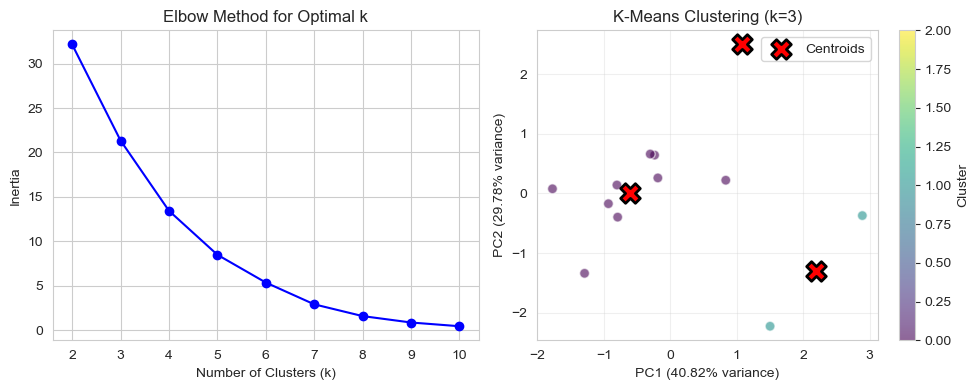


Cluster Statistics:

Cluster 0 (n=9):
      nmb_menu_items    avg_fat  avg_real_estate_cost  nmb_of_restaurants
mean       11.666667  30.017547         404627.771521          258.666667
std         1.000000   5.786158         164569.086850          290.398864

Cluster 1 (n=2):
      nmb_menu_items    avg_fat  avg_real_estate_cost  nmb_of_restaurants
mean             5.0  19.550000         564196.339370           141.00000
std              0.0  10.253048         237852.641066           123.03658

Cluster 2 (n=1):
      nmb_menu_items    avg_fat  avg_real_estate_cost  nmb_of_restaurants
mean            11.0  20.363636         391521.562674              1951.0
std              NaN        NaN                   NaN                 NaN


Cluster Distribution:
cluster
0    9
1    2
2    1
Name: count, dtype: int64


In [92]:
# Select features for clustering (exclude non-numeric or ID columns)
features = cluster_df.select_dtypes(include=[np.number]).columns.tolist()
X = cluster_df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Perform k-means clustering with chosen k (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
cluster_df['cluster'] = clusters

# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot of clusters
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=clusters, cmap='viridis',
                      alpha=0.6, edgecolors='w', s=50)

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            c='red', marker='X', s=200,
            edgecolors='black', linewidths=2,
            label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
print("="*50)
for i in range(optimal_k):
    cluster_data = cluster_df[cluster_df['cluster'] == i]
    print(f"\nCluster {i} (n={len(cluster_data)}):")
    print(cluster_data[features].describe().loc[['mean', 'std']])

# Print cluster distribution
print("\n\nCluster Distribution:")
print(cluster_df['cluster'].value_counts().sort_index())

In [93]:
# Display cluster members (indices or row identifiers)
print("\n\nCluster Members:")
print("="*50)
for i in range(optimal_k):
    cluster_members = cluster_df[cluster_df['cluster'] == i].index.tolist()
    print(f"\nCluster {i}: {cluster_members}")



Cluster Members:

Cluster 0: [0, 1, 3, 4, 6, 8, 9, 10, 11]

Cluster 1: [2, 5]

Cluster 2: [7]


In [96]:
cluster_df[['cluster','restaurant']]

,cluster,restaurant
0,0,Burger King
1,0,Carl's Jr.
2,1,Chick-fil-A
3,0,Dairy Queen
4,0,Hardee's
5,1,In-N-Out Burger
6,0,Jack in the Box
7,2,McDonald's
8,0,Sonic
9,0,Wendy's
